We estimate the accuracy threshold of the toric code assuming no measurement error.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag
from pymatching import Matching

Construct a matrix $H$ such that $H_{i,j}$ is 1 if the $i$ th $X$ stabiliser acts on 
the $j$ th qubit, and is 0 otherwise. L is the side length of the lattice.

In [28]:
def repetition_code(n):
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def x_stabilisers(L):
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

Construct a matrix with two rows where row i corresponding to an X logical operator $\bar{X}_i$.

In [25]:
def x_logicals(L):
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    x_logicals = block_diag([kron(H1, H0), kron(H0, H1)])
    x_logicals.data = x_logicals.data % 2
    x_logicals.eliminate_zeros()
    return csc_matrix(x_logicals)

decoding_fail_prob(stab, logicals, error_probability, num_shots): 

Given: 

stab: stabilizers

logicals: logical operators

error_probability: probability of Z-error on each qubit

num_shots: number of simulations

Returns:

the estimated probability that the minimum weight matching decoder fails to predict the true logical qubits correctly.

In [31]:
def decoding_fail_prob(stab, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(stab, weights=np.log((1-p)/p), faults_matrix=logicals)
    noise = (np.random.random((num_shots, stab.shape[1])) < error_probability).astype(np.uint8)
    syndromes = (noise @ stab.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(syndromes)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors / num_shots

In [35]:
num_shots = 5000
Ls = range(3,30,3)
ps = np.linspace(0.01, 0.2, 20)

log_errors_all_L = []

for L in Ls:
    stabilizers = x_stabilisers(L)
    logicals = x_logicals(L)
    log_errors = []
    for p in ps:
        log_errors.append(decoding_fail_prob(stabilizers, logicals, p, num_shots))
    log_errors_all_L.append(np.array(log_errors))

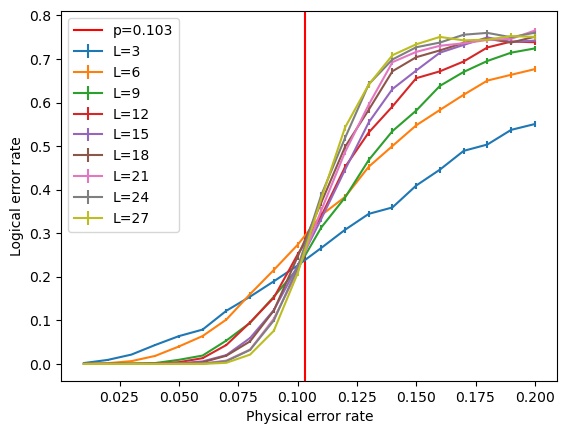

In [39]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.axvline(x=0.103, c='red', label='p=0.103')
plt.legend(loc=0);